This is a quick inspection of RTP-007 (E2V) and RTM-011 (ITL) with respect to serial hysteresis, which potentially includes "classical" CTI short trapping as well as a longer decay signal, under the assumption that the latter is due to amplifier effects.  First we're going to look at the difference of the total effect between high level (70k ADU), low level (24k ADU), and bias frames.

The notebook was run on 2018_45 on 2018-11-14.

First we import stuff and setup some params.

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

Check that obs_lsst is properly setup in the nb environment. If the following cell raises an exception, see the instructions in `examples/welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

If we want to look at the pixel images, we load firefly.  

In [4]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

Identify RTM-007 (E2V) or RTM-011 (ITL) repo and point the butler to it.

In [5]:
#BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-011/'
butler = Butler(BOOTCAMP_REPO_DIR)

Using the superflats, find the proper visit numbers for high, low, bias.

In [6]:
#for example E2V run
#longexposurevisits = butler.queryMetadata('raw', ['visit'], dataId={'testType': 'SFLAT_500', 'exptime': 33.746})
#shortexposurevisits = butler.queryMetadata('raw', ['visit'], dataId={'testType': 'SFLAT_500', 'exptime': 0.677})
#biasvisits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'BIAS', 'testType': 'SFLAT'})
# for example ITL run
longexposurevisits = butler.queryMetadata('raw', ['visit'], dataId={'testType': 'SFLAT_500', 'exptime': 148.766})
shortexposurevisits = butler.queryMetadata('raw', ['visit'], dataId={'testType': 'SFLAT_500', 'exptime': 3.112})
biasvisits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'BIAS', 'testType': 'SFLAT'})

Line below is exploring what is available via the metadata in the butler db.

In [7]:
#print("Available visits: %s" % ("".join(str(butler.queryMetadata('raw', ['run','visit','testType','imageType','wavelength','exptime']))))) 

Now here we get the first raw (high level) exposure, looking at the central sensor, and get that image.

In [8]:
dId=dict(visit=longexposurevisits[0],detectorName='S11')
ref = butler.dataRef("raw",**dId)
raw = ref.get('raw')

In [9]:
detector = raw.getDetector()

If one wishes, you can display the pixels.

In [10]:
#afw_display.mtv(raw)

This defines the flipping of electronics to detector coordinates.  Note that afw_display takes care of this for display purposes (previous line).

In [11]:
# for the geometry we've chosen, the y=0 amps are in the top
# Normally the read corner would tell you this, but there is currently a bug
# this is e2v only
#flipXY = {'C00':(False, True),
#          'C01':(False, True),
#          'C02':(False, True),
#          'C03':(False, True),
#          'C04':(False, True),
#          'C05':(False, True),
#          'C06':(False, True),
#          'C07':(False, True),
#          'C10':(True, False),
#          'C11':(True, False),
#          'C12':(True, False),
#          'C13':(True, False),
#          'C14':(True, False),
#          'C15':(True, False),
#          'C16':(True, False),
#          'C17':(True, False)}
# this is for ITL only (according to policy/lsstCam.yaml)
flipXY = {'C00':(False, True),
          'C01':(False, True),
          'C02':(False, True),
          'C03':(False, True),
          'C04':(False, True),
          'C05':(False, True),
          'C06':(False, True),
          'C07':(False, True),
          'C10':(True, False),
          'C11':(True, False),
          'C12':(True, False),
          'C13':(True, False),
          'C14':(True, False),
          'C15':(True, False),
          'C16':(True, False),
          'C17':(True, False)}
# for testing, just look at the C12 amplifier
#flipXY = {'C12':(True, False)}


Get the real detector amp pixels (no overscan), detector amp pixels (with overscan), and overscan only pixels.

In [12]:
allpixels = {}
detectorpixels = {}
overscanpixels = {}
for key, value in flipXY.items():
        detbbox = detector[key].getBBox()
        allbbox = detector[key].getRawBBox()
        overscanbbox = detector[key].getRawHorizontalOverscanBBox()
        detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
        allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
        overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

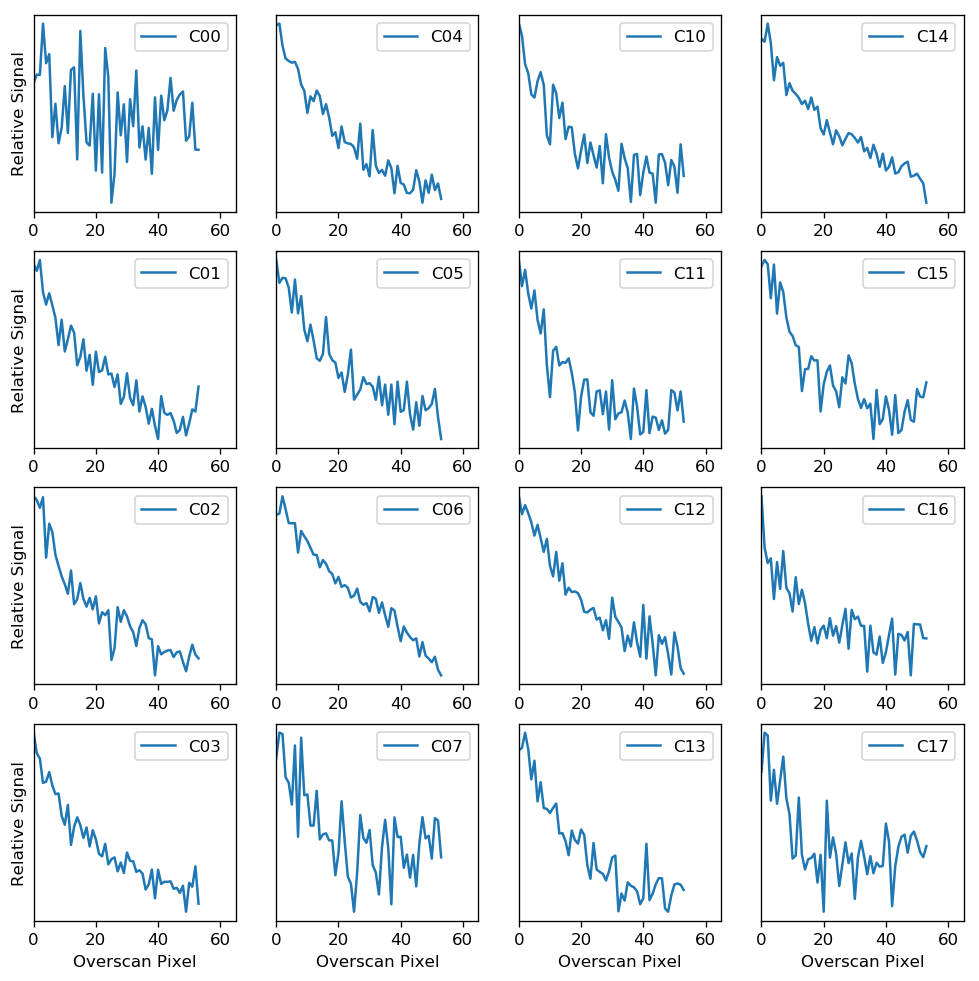

In [13]:
overscanmeans = {}
allmeans = {}
detmeans = {}
longcti = {}
i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
    detarr = detectorpixels[channel_name].getArray() # pull out numpy array
    allarr = allpixels[channel_name].getArray() # pull out numpy array
    overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
    fx, fy = flips
    if fx:
        detarr = numpy.flip(detarr, axis=1)
        allarr = numpy.flip(allarr, axis=1)
        overscanarr = numpy.flip(overscanarr, axis=1)
    if fy:
        detarr = numpy.flip(detarr, axis=0)
        allarr = numpy.flip(allarr, axis=0)
        overscanarr = numpy.flip(overscanarr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmeans[channel_name] = numpy.mean(overscanarr, axis=0)
    allmeans[channel_name] = numpy.mean(allarr, axis=0)
    # get the mean level in the detector
    detmeans[channel_name] = numpy.mean(detarr)
    longcti[channel_name]=overscanmeans[channel_name]/detmeans[channel_name]
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].semilogy(overscanmeans[channel_name]/detmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(0,65)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('Overscan Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Relative Signal')


In [14]:
# for low flux
dId=dict(visit=shortexposurevisits[0],detectorName='S11')
ref = butler.dataRef("raw",**dId)
raw = ref.get('raw')

In [15]:
detector = raw.getDetector()

In [16]:
allpixels = {}
detectorpixels = {}
overscanpixels = {}
for key, value in flipXY.items():
        detbbox = detector[key].getBBox()
        allbbox = detector[key].getRawBBox()
        overscanbbox = detector[key].getRawHorizontalOverscanBBox()
        detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
        allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
        overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

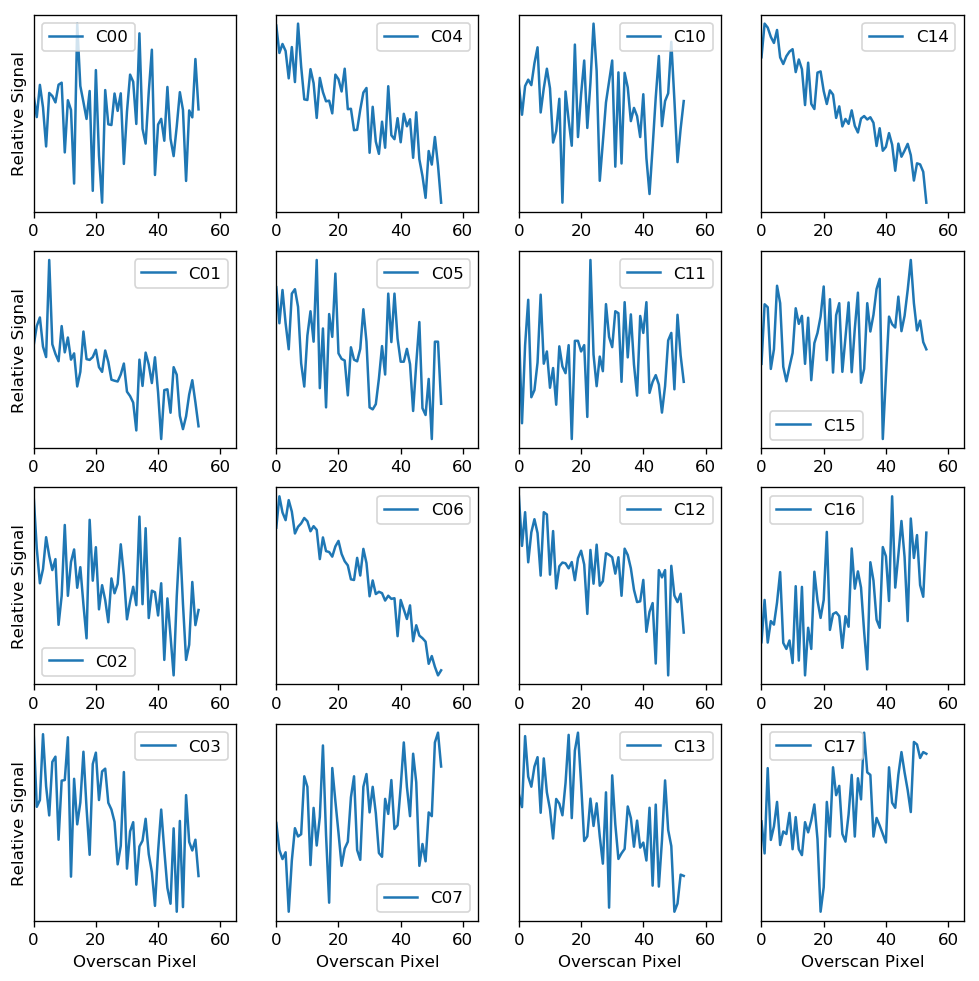

In [17]:
overscanmeans = {}
allmeans = {}
detmeans = {}
longcti = {}
i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
    detarr = detectorpixels[channel_name].getArray() # pull out numpy array
    allarr = allpixels[channel_name].getArray() # pull out numpy array
    overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
    fx, fy = flips
    if fx:
        detarr = numpy.flip(detarr, axis=1)
        allarr = numpy.flip(allarr, axis=1)
        overscanarr = numpy.flip(overscanarr, axis=1)
    if fy:
        detarr = numpy.flip(detarr, axis=0)
        allarr = numpy.flip(allarr, axis=0)
        overscanarr = numpy.flip(overscanarr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmeans[channel_name] = numpy.mean(overscanarr, axis=0)
    allmeans[channel_name] = numpy.mean(allarr, axis=0)
    # get the mean level in the detector
    detmeans[channel_name] = numpy.mean(detarr)
    longcti[channel_name]=overscanmeans[channel_name]/detmeans[channel_name]
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].semilogy(overscanmeans[channel_name]/detmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(0,65)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('Overscan Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Relative Signal')


In [18]:
# for bias
dId=dict(visit=biasvisits[0],detectorName='S11')
ref = butler.dataRef("raw",**dId)
raw = ref.get('raw')

In [19]:
detector = raw.getDetector()

In [20]:
allpixels = {}
detectorpixels = {}
overscanpixels = {}
for key, value in flipXY.items():
        detbbox = detector[key].getBBox()
        allbbox = detector[key].getRawBBox()
        overscanbbox = detector[key].getRawHorizontalOverscanBBox()
        detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
        allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
        overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

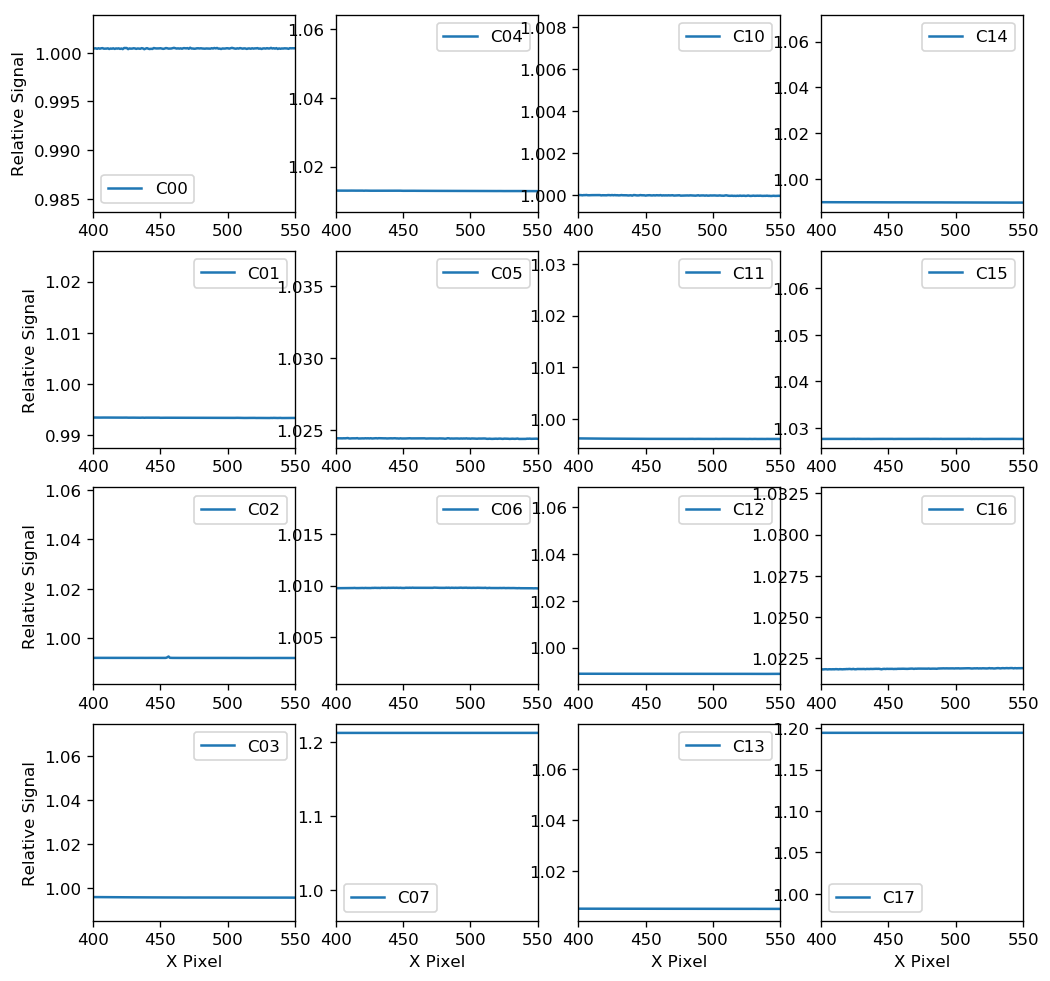

In [21]:
overscanmeans = {}
allmeans = {}
detmeans = {}
i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
    detarr = detectorpixels[channel_name].getArray() # pull out numpy array
    allarr = allpixels[channel_name].getArray() # pull out numpy array
    overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
    fx, fy = flips
    if fx:
        detarr = numpy.flip(detarr, axis=1)
        allarr = numpy.flip(allarr, axis=1)
        overscanarr = numpy.flip(overscanarr, axis=1)
    if fy:
        detarr = numpy.flip(detarr, axis=0)
        allarr = numpy.flip(allarr, axis=0)
        overscanarr = numpy.flip(overscanarr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmeans[channel_name] = numpy.mean(overscanarr, axis=0)
    allmeans[channel_name] = numpy.mean(allarr, axis=0)
    # get the mean level in the detector
    detmeans[channel_name] = numpy.mean(detarr)
    longcti[channel_name]=overscanmeans[channel_name]/detmeans[channel_name]
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].plot(allmeans[channel_name]/detmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(400,550)
#    axs[indx][indy].set_ylim(0.99,1.01)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('X Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Relative Signal')



okay, let's try to sum these to get better SNR.

now iterate over all of the visits and take mean

0
1
2
3
4
5
6
7
8
9


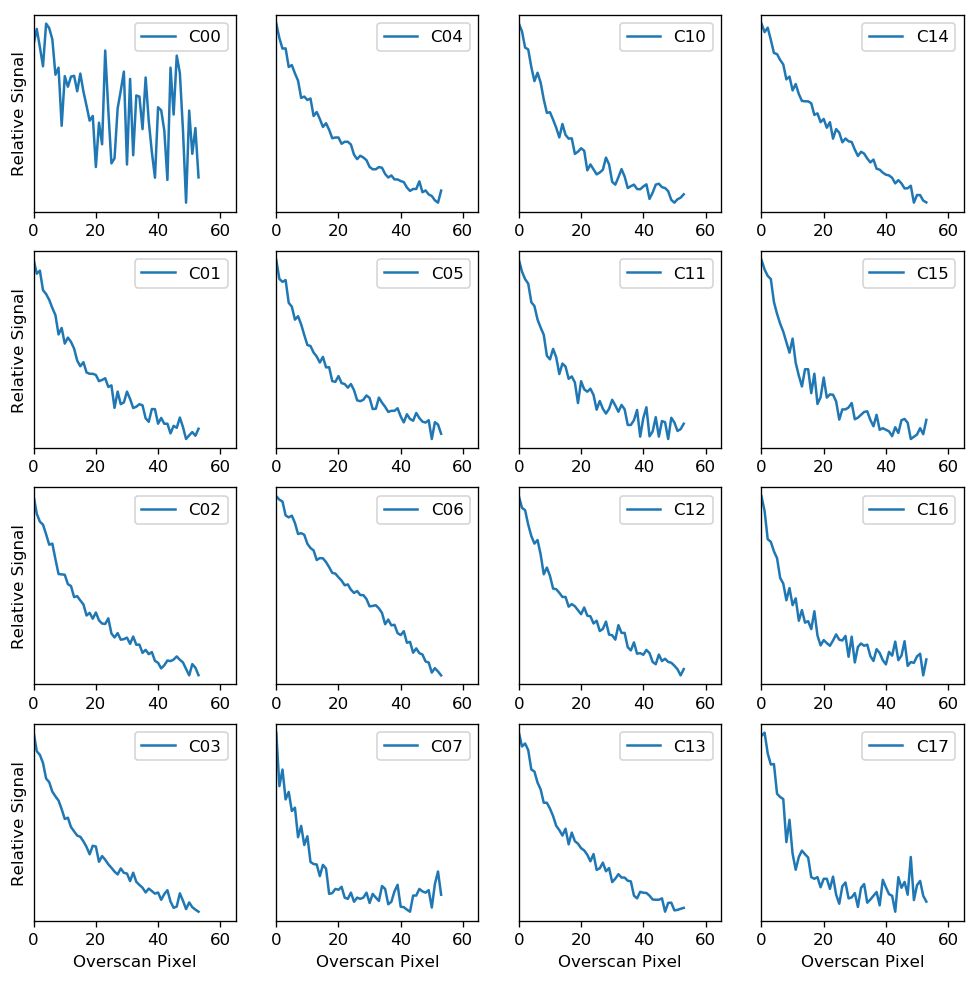

In [22]:
sumdetarr = {}
sumallarr = {}
sumoverscanarr = {}
sumoverscanmeans = {}
sumallmeans = {}
sumdetmeans = {}
longcti = {}
for visitcounter in range(len(longexposurevisits)):
    print(visitcounter)
    dId=dict(visit=longexposurevisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    detarr = {}
    allarr = {}
    overscanarr = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr[channel_name] = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr[channel_name] = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr[channel_name] = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=1)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=1)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=1)
        if fy:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=0)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=0)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=0)
        if visitcounter==0:
            sumdetarr[channel_name]=detarr[channel_name].copy()
            sumallarr[channel_name]=allarr[channel_name].copy()
            sumoverscanarr[channel_name]=overscanarr[channel_name].copy()
        if visitcounter!=0:
            sumdetarr[channel_name]+=detarr[channel_name]
            sumallarr[channel_name]+=allarr[channel_name]
            sumoverscanarr[channel_name]+=overscanarr[channel_name]

i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    sumoverscanmeans[channel_name] = numpy.mean(sumoverscanarr[channel_name], axis=0)
    # get the mean level in the detector
    sumdetmeans[channel_name] = numpy.mean(sumdetarr[channel_name])
    longcti[channel_name]=sumoverscanmeans[channel_name]/sumdetmeans[channel_name]
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].semilogy(sumoverscanmeans[channel_name]/sumdetmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(0,65)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('Overscan Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Relative Signal')



for low flux:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
674575.56
644804.4
626387.94
618644.8
624252.25
640657.44
657292.4
682672.75
659519.56
644039.94
622255.25
620929.25
618442.94
622927.06
644547.2
676213.6


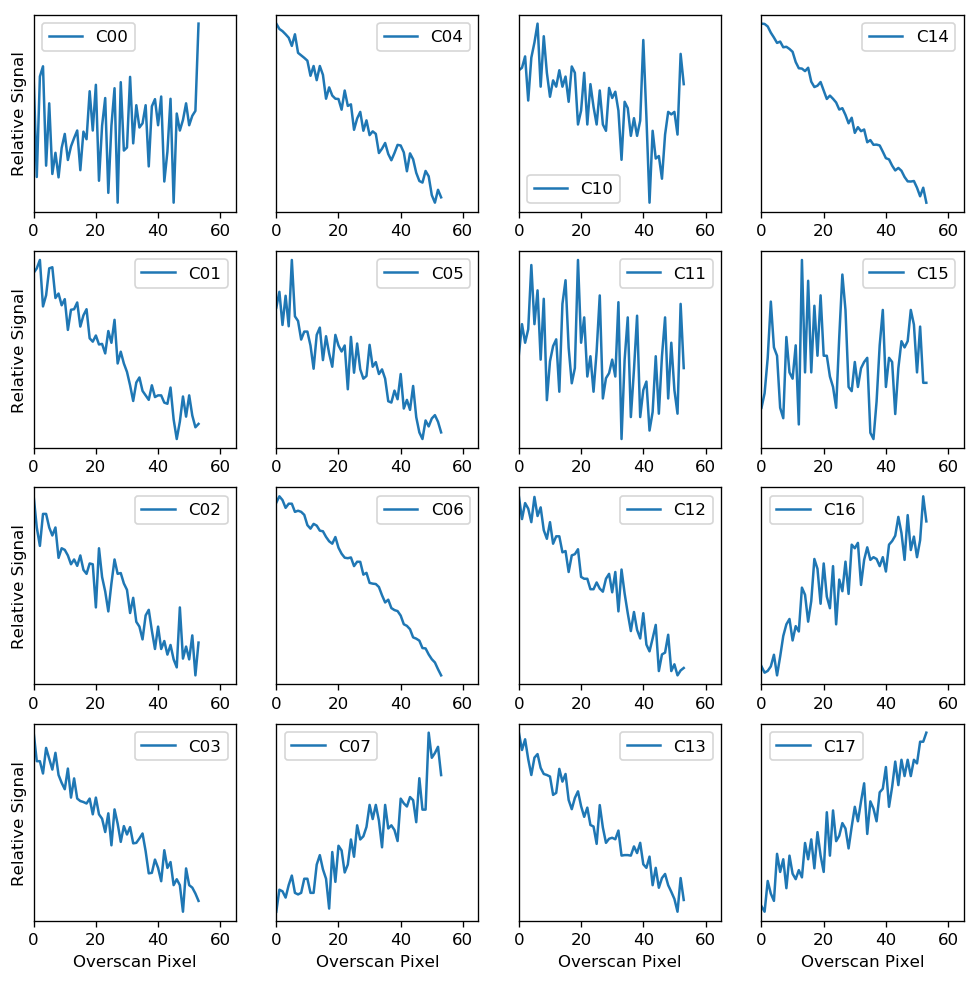

In [23]:
sumdetarr = {}
sumallarr = {}
sumoverscanarr = {}
sumoverscanmeans = {}
sumallmeans = {}
sumdetmeans = {}
shortcti = {}
for visitcounter in range(len(shortexposurevisits)):
    print(visitcounter)
    dId=dict(visit=shortexposurevisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    detarr = {}
    allarr = {}
    overscanarr = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr[channel_name] = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr[channel_name] = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr[channel_name] = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=1)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=1)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=1)
        if fy:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=0)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=0)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=0)
        if visitcounter==0:
            sumdetarr[channel_name]=detarr[channel_name].copy()
            sumallarr[channel_name]=allarr[channel_name].copy()
            sumoverscanarr[channel_name]=overscanarr[channel_name].copy()
        if visitcounter!=0:
            sumdetarr[channel_name]+=detarr[channel_name]
            sumallarr[channel_name]+=allarr[channel_name]
            sumoverscanarr[channel_name]+=overscanarr[channel_name]

i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    sumoverscanmeans[channel_name] = numpy.mean(sumoverscanarr[channel_name], axis=0)
    # get the mean level in the detector
    sumdetmeans[channel_name] = numpy.mean(sumdetarr[channel_name])
    shortcti[channel_name]=sumoverscanmeans[channel_name]/sumdetmeans[channel_name]
    indx = i%4
    indy = i//4
    i+=1
    print(sumdetmeans[channel_name])
    axs[indx][indy].semilogy(sumoverscanmeans[channel_name]/sumdetmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(0,65)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('Overscan Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Relative Signal')


for bias exposures:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


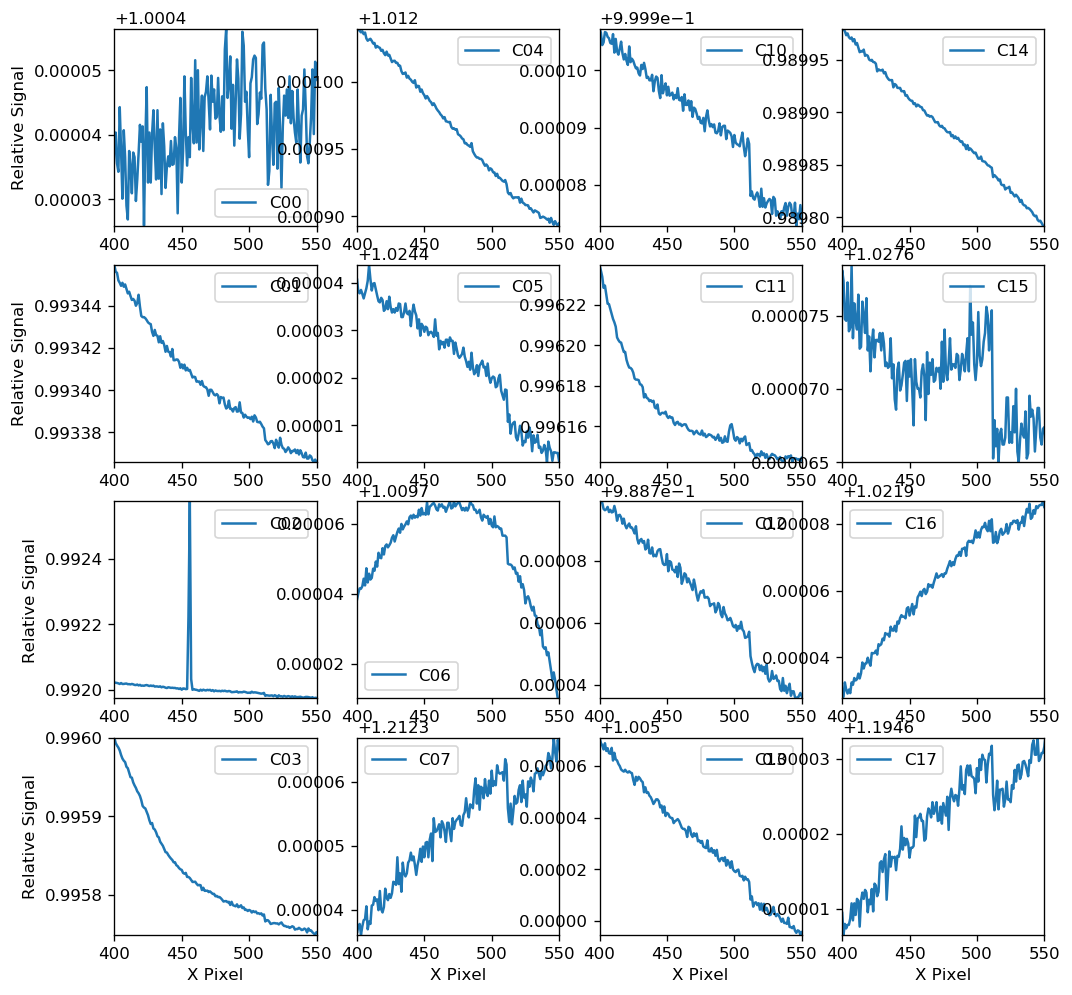

In [24]:
sumdetarr = {}
sumallarr = {}
sumoverscanarr = {}
sumoverscanmeans = {}
sumallmeans = {}
sumdetmeans = {}
longcti = {}
for visitcounter in range(len(biasvisits)):
    print(visitcounter)
    dId=dict(visit=biasvisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    detarr = {}
    allarr = {}
    overscanarr = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr[channel_name] = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr[channel_name] = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr[channel_name] = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=1)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=1)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=1)
        if fy:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=0)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=0)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=0)
        if visitcounter==0:
            sumdetarr[channel_name]=detarr[channel_name].copy()
            sumallarr[channel_name]=allarr[channel_name].copy()
            sumoverscanarr[channel_name]=overscanarr[channel_name].copy()
        if visitcounter!=0:
            sumdetarr[channel_name]+=detarr[channel_name]
            sumallarr[channel_name]+=allarr[channel_name]
            sumoverscanarr[channel_name]+=overscanarr[channel_name]

i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    sumallmeans[channel_name] = numpy.mean(sumallarr[channel_name], axis=0)
    # get the mean level in the detector
    sumdetmeans[channel_name] = numpy.mean(sumdetarr[channel_name])
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].plot(sumallmeans[channel_name]/sumdetmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(400,550)
    limitlow=numpy.min(sumallmeans[channel_name][400:550]/sumdetmeans[channel_name])
    limithigh=numpy.max(sumallmeans[channel_name][400:550]/sumdetmeans[channel_name])
    axs[indx][indy].set_ylim(limitlow,limithigh)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('X Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Relative Signal')



We concur that there is at least two components to the deffered charge with different timescales.  We also think that we're seeing an flux dependence in the bias.

We now want to look at the parallel (columns) profiles to see if we see this "light leak".


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


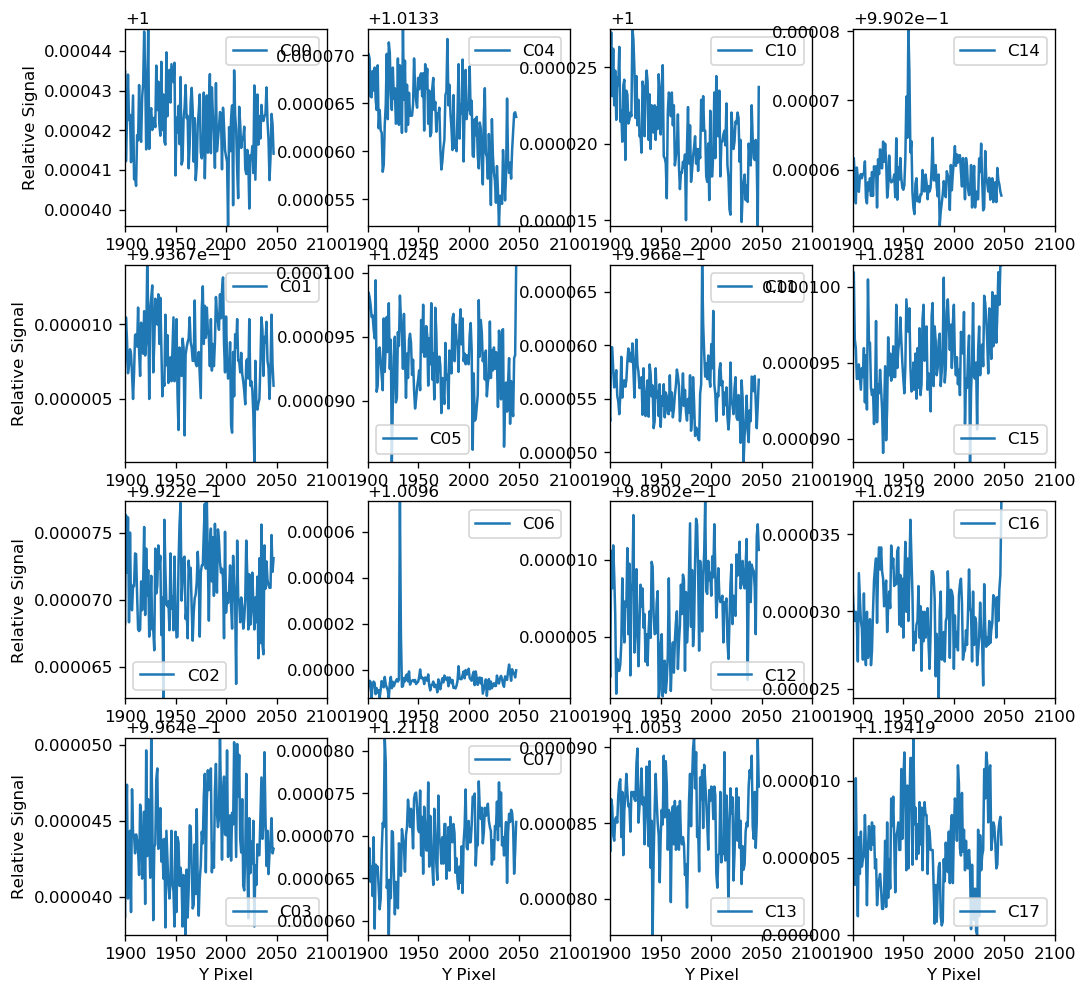

In [25]:
sumdetarr = {}
sumallarr = {}
sumoverscanarr = {}
sumoverscanmeans = {}
sumallmeans = {}
sumdetmeans = {}
longcti = {}
for visitcounter in range(len(biasvisits)):
    print(visitcounter)
    dId=dict(visit=biasvisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    detarr = {}
    allarr = {}
    overscanarr = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr[channel_name] = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr[channel_name] = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr[channel_name] = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=1)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=1)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=1)
        if fy:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=0)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=0)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=0)
        if visitcounter==0:
            sumdetarr[channel_name]=detarr[channel_name].copy()
            sumallarr[channel_name]=allarr[channel_name].copy()
            sumoverscanarr[channel_name]=overscanarr[channel_name].copy()
        if visitcounter!=0:
            sumdetarr[channel_name]+=detarr[channel_name]
            sumallarr[channel_name]+=allarr[channel_name]
            sumoverscanarr[channel_name]+=overscanarr[channel_name]

i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    sumallmeans[channel_name] = numpy.mean(sumallarr[channel_name], axis=1)
    # get the mean level in the detector
    sumdetmeans[channel_name] = numpy.mean(sumdetarr[channel_name])
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].plot(sumallmeans[channel_name]/sumdetmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(1900,2100)
    limitlow=numpy.min(sumallmeans[channel_name][1900:2100]/sumdetmeans[channel_name])
    limithigh=numpy.max(sumallmeans[channel_name][1900:2100]/sumdetmeans[channel_name])
    axs[indx][indy].set_ylim(limitlow,limithigh)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('Y Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Relative Signal')



Ok, not a light leak, interesting...  Now we should look at the variance of the bias frames horizontal profiles to see if the bias frames are at least stable.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


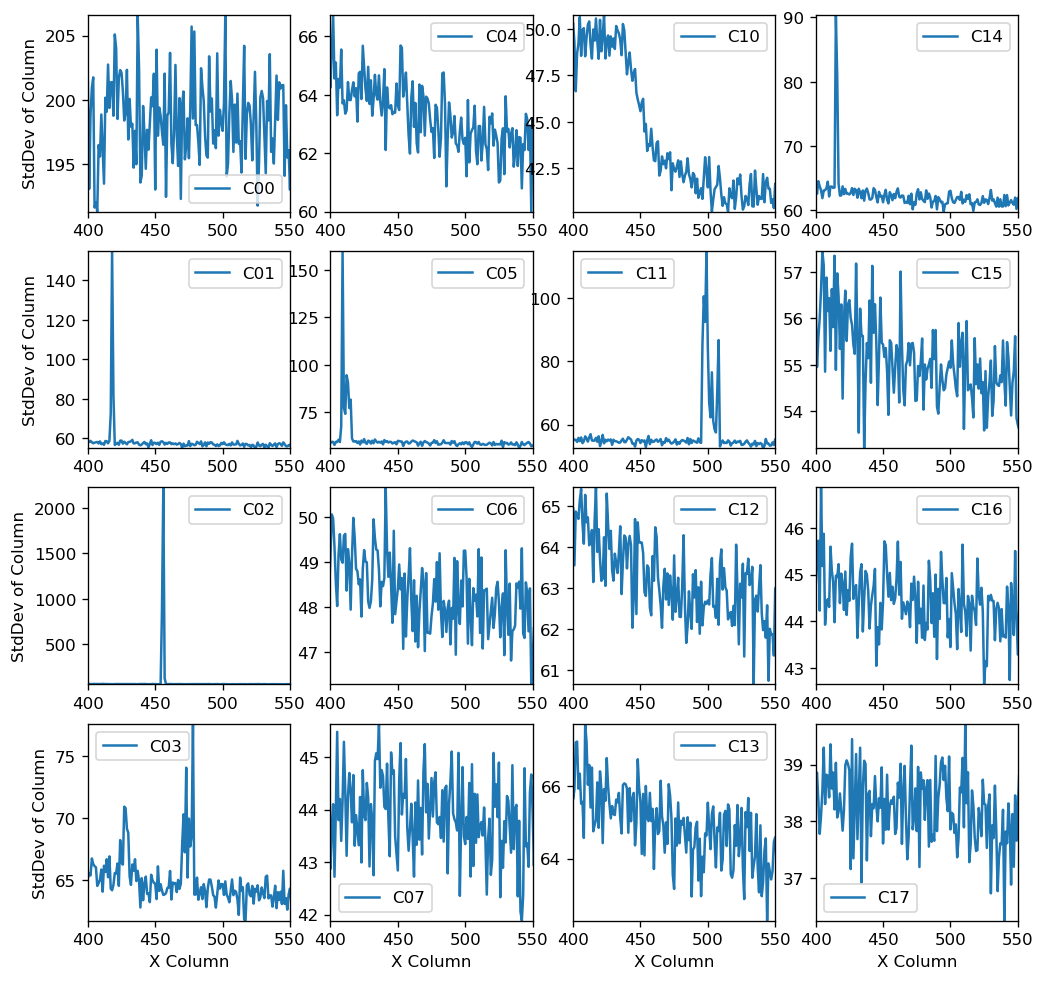

In [41]:
sumdetarr = {}
sumallarr = {}
sumoverscanarr = {}
sumoverscanstds = {}
sumallstds = {}
sumdetstds = {}
longcti = {}
for visitcounter in range(len(biasvisits)):
    print(visitcounter)
    dId=dict(visit=biasvisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    detarr = {}
    allarr = {}
    overscanarr = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr[channel_name] = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr[channel_name] = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr[channel_name] = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=1)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=1)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=1)
        if fy:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=0)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=0)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=0)
        if visitcounter==0:
            sumdetarr[channel_name]=detarr[channel_name].copy()
            sumallarr[channel_name]=allarr[channel_name].copy()
            sumoverscanarr[channel_name]=overscanarr[channel_name].copy()
        if visitcounter!=0:
            sumdetarr[channel_name]+=detarr[channel_name]
            sumallarr[channel_name]+=allarr[channel_name]
            sumoverscanarr[channel_name]+=overscanarr[channel_name]

i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    sumallstds[channel_name] = numpy.std(sumallarr[channel_name], axis=0)
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].plot(sumallstds[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(400,550)
    limitlow=numpy.min(sumallstds[channel_name][400:550])
    limithigh=numpy.max(sumallstds[channel_name][400:550])
    axs[indx][indy].set_ylim(limitlow,limithigh)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('X Column')
    if indy == 0:
        axs[indx][indy].set_ylabel('StdDev of Column')



So it seems that the structure is flat and doesn't vary (much).  We conclude that the current ISR (subtract a master bias then do a vertical spline fit to the overscan level and subtract that) should do very well.  Now that we've convinced ourselves of this, we should return to the original CTI/deferred charge question...

let's make a master high level image

In [27]:
sumdetarr = {}
sumallarr = {}
sumoverscanarr = {}
sumoverscanmeans = {}
sumallmeans = {}
sumdetmeans = {}
longcti = {}
for visitcounter in range(len(longexposurevisits)):
    print(visitcounter)
    dId=dict(visit=longexposurevisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    detarr = {}
    allarr = {}
    overscanarr = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr[channel_name] = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr[channel_name] = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr[channel_name] = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=1)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=1)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=1)
        if fy:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=0)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=0)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=0)
        if visitcounter==0:
            sumdetarr[channel_name]=detarr[channel_name].copy()
            sumallarr[channel_name]=allarr[channel_name].copy()
            sumoverscanarr[channel_name]=overscanarr[channel_name].copy()
        if visitcounter!=0:
            sumdetarr[channel_name]+=detarr[channel_name]
            sumallarr[channel_name]+=allarr[channel_name]
            sumoverscanarr[channel_name]+=overscanarr[channel_name]

longexpdetarr = {}
longexpallarr = {}
longexpoverscanarr = {}
for channel_name, flips in flipXY.items():
    longexpdetarr[channel_name]=sumdetarr[channel_name]/len(longexposurevisits)
    longexpallarr[channel_name]=sumallarr[channel_name]/len(longexposurevisits)
    longexpoverscanarr[channel_name]=sumoverscanarr[channel_name]/len(longexposurevisits)
    

0
1
2
3
4
5
6
7
8
9


then master low level:

In [28]:
sumdetarr = {}
sumallarr = {}
sumoverscanarr = {}
sumoverscanmeans = {}
sumallmeans = {}
sumdetmeans = {}
longcti = {}
for visitcounter in range(len(shortexposurevisits)):
    print(visitcounter)
    dId=dict(visit=shortexposurevisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    detarr = {}
    allarr = {}
    overscanarr = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr[channel_name] = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr[channel_name] = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr[channel_name] = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=1)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=1)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=1)
        if fy:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=0)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=0)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=0)
        if visitcounter==0:
            sumdetarr[channel_name]=detarr[channel_name].copy()
            sumallarr[channel_name]=allarr[channel_name].copy()
            sumoverscanarr[channel_name]=overscanarr[channel_name].copy()
        if visitcounter!=0:
            sumdetarr[channel_name]+=detarr[channel_name]
            sumallarr[channel_name]+=allarr[channel_name]
            sumoverscanarr[channel_name]+=overscanarr[channel_name]

shortexpdetarr = {}
shortexpallarr = {}
shortexpoverscanarr = {}
for channel_name, flips in flipXY.items():
    shortexpdetarr[channel_name]=sumdetarr[channel_name]/len(shortexposurevisits)
    shortexpallarr[channel_name]=sumallarr[channel_name]/len(shortexposurevisits)
    shortexpoverscanarr[channel_name]=sumoverscanarr[channel_name]/len(shortexposurevisits)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


and master bias:

In [29]:
sumdetarr = {}
sumallarr = {}
sumoverscanarr = {}
sumoverscanmeans = {}
sumallmeans = {}
sumdetmeans = {}
for visitcounter in range(len(biasvisits)):
    print(visitcounter)
    dId=dict(visit=biasvisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    detarr = {}
    allarr = {}
    overscanarr = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr[channel_name] = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr[channel_name] = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr[channel_name] = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=1)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=1)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=1)
        if fy:
            detarr[channel_name] = numpy.flip(detarr[channel_name], axis=0)
            allarr[channel_name] = numpy.flip(allarr[channel_name], axis=0)
            overscanarr[channel_name] = numpy.flip(overscanarr[channel_name], axis=0)
        if visitcounter==0:
            sumdetarr[channel_name]=detarr[channel_name].copy()
            sumallarr[channel_name]=allarr[channel_name].copy()
            sumoverscanarr[channel_name]=overscanarr[channel_name].copy()
        if visitcounter!=0:
            sumdetarr[channel_name]+=detarr[channel_name]
            sumallarr[channel_name]+=allarr[channel_name]
            sumoverscanarr[channel_name]+=overscanarr[channel_name]

biasdetarr = {}
biasallarr = {}
biasoverscanarr = {}
for channel_name, flips in flipXY.items():
    biasdetarr[channel_name]=sumdetarr[channel_name]/len(biasvisits)
    biasallarr[channel_name]=sumallarr[channel_name]/len(biasvisits)
    biasoverscanarr[channel_name]=sumoverscanarr[channel_name]/len(biasvisits)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


Let's look at the high and low level flats after bias subtraction

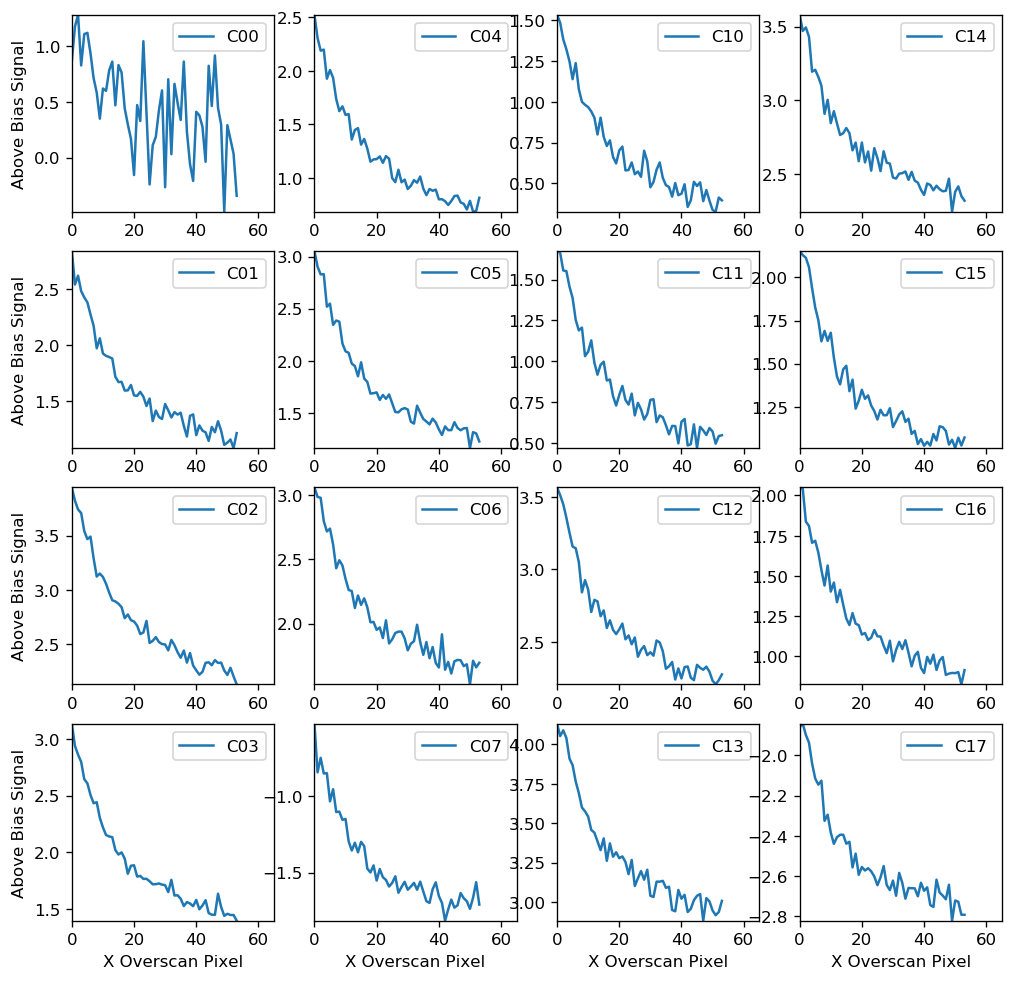

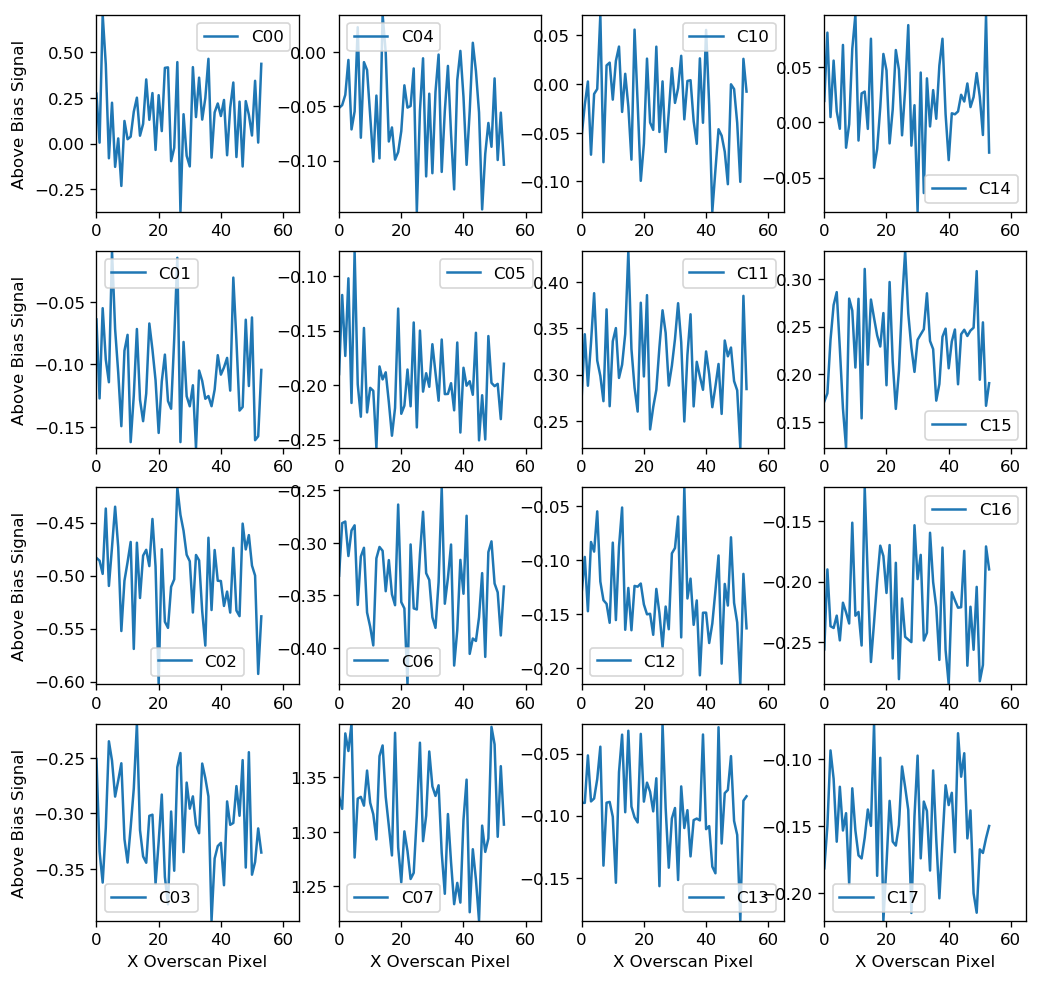

In [30]:
detmeans = {}
allmeans = {}
overscanmeans = {}

i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmeans[channel_name] = numpy.mean(longexpoverscanarr[channel_name]-biasoverscanarr[channel_name], axis=0)
    allmeans[channel_name] = numpy.mean(longexpallarr[channel_name]-biasallarr[channel_name], axis=0)
    # get the mean level in the detector
    detmeans[channel_name] = numpy.mean(longexpdetarr[channel_name]-biasdetarr[channel_name])
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].plot(overscanmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(0,65)
    limitlow=numpy.min(overscanmeans[channel_name][0:65])
    limithigh=numpy.max(overscanmeans[channel_name][0:65])
    axs[indx][indy].set_ylim(limitlow,limithigh)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('X Overscan Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Above Bias Signal')

detmeans = {}
allmeans = {}
overscanmeans = {}

i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmeans[channel_name] = numpy.mean(shortexpoverscanarr[channel_name]-biasoverscanarr[channel_name], axis=0)
    allmeans[channel_name] = numpy.mean(shortexpallarr[channel_name]-biasallarr[channel_name], axis=0)
    # get the mean level in the detector
    detmeans[channel_name] = numpy.mean(shortexpdetarr[channel_name]-biasdetarr[channel_name])
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].plot(overscanmeans[channel_name], label=channel_name)
    axs[indx][indy].set_xlim(0,65)
    limitlow=numpy.min(overscanmeans[channel_name][0:65])
    limithigh=numpy.max(overscanmeans[channel_name][0:65])
    axs[indx][indy].set_ylim(limitlow,limithigh)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('X Overscan Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Above Bias Signal')



and the ratio of the two (scaling from the detector levels):

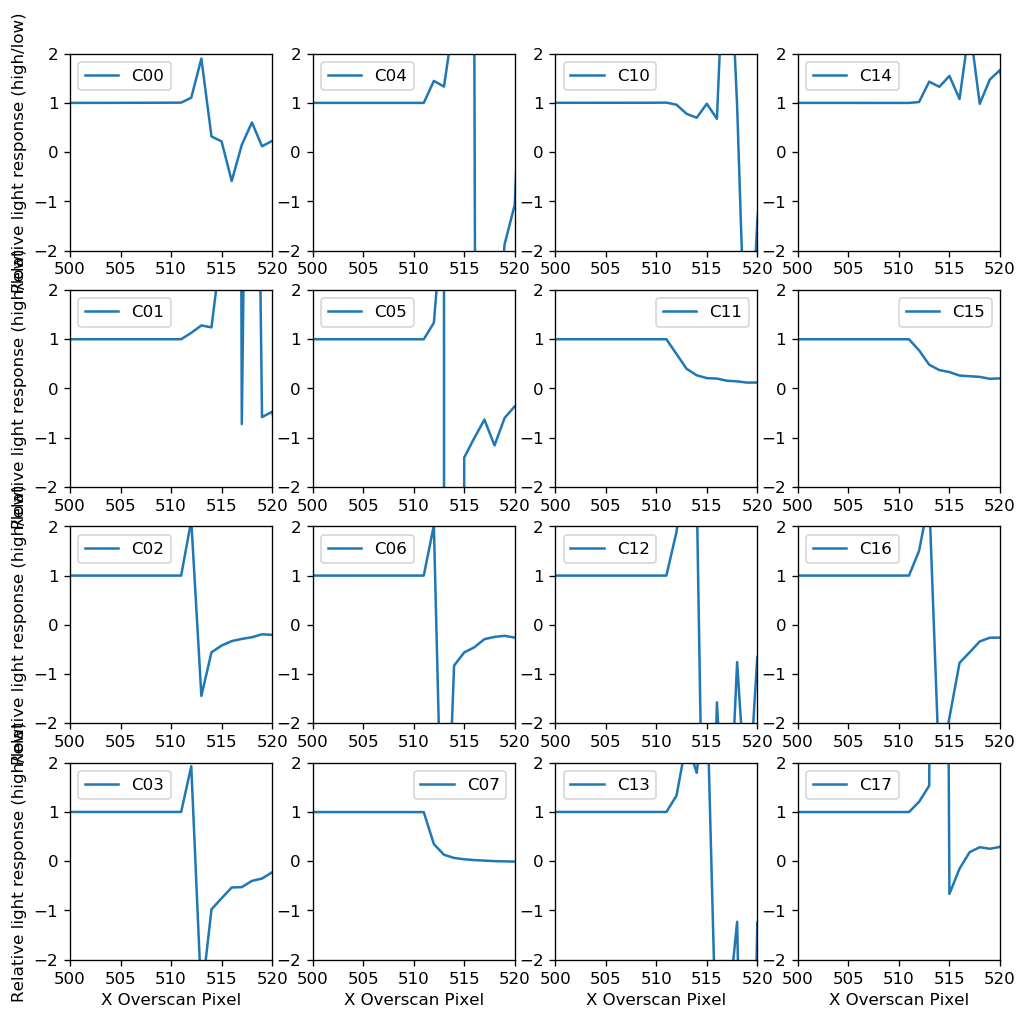

In [39]:
highdetmeans = {}
highallmeans = {}
highoverscanmeans = {}
lowdetmeans = {}
lowallmeans = {}
lowoverscanmeans = {}


i=0
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    highoverscanmeans[channel_name] = numpy.mean(longexpoverscanarr[channel_name]-biasoverscanarr[channel_name], axis=0)
    highallmeans[channel_name] = numpy.mean(longexpallarr[channel_name]-biasallarr[channel_name], axis=0)
    lowoverscanmeans[channel_name] = numpy.mean(shortexpoverscanarr[channel_name]-biasoverscanarr[channel_name], axis=0)
    lowallmeans[channel_name] = numpy.mean(shortexpallarr[channel_name]-biasallarr[channel_name], axis=0)
    # get the mean level in the detector
    highdetmeans[channel_name] = numpy.mean(longexpdetarr[channel_name]-biasdetarr[channel_name])
    lowdetmeans[channel_name] = numpy.mean(shortexpdetarr[channel_name]-biasdetarr[channel_name])
    indx = i%4
    indy = i//4
    i+=1
    axs[indx][indy].plot(highallmeans[channel_name]/highdetmeans[channel_name]/(lowallmeans[channel_name]/lowdetmeans[channel_name]), label=channel_name)
    axs[indx][indy].set_xlim(500,520)
    limitlow=numpy.min(highallmeans[channel_name][500:520]/highdetmeans[channel_name]/(lowallmeans[channel_name][500:520]/lowdetmeans[channel_name]))
    limithigh=numpy.max(highallmeans[channel_name][500:520]/highdetmeans[channel_name]/(lowallmeans[channel_name][500:520]/lowdetmeans[channel_name]))
#    axs[indx][indy].set_ylim(limitlow,limithigh)
    axs[indx][indy].set_ylim(-2,2)
    axs[indx][indy].legend()
    if indx == 3:
        axs[indx][indy].set_xlabel('X Overscan Pixel')
    if indy == 0:
        axs[indx][indy].set_ylabel('Relative light response (high/low)')

detmeans = {}
allmeans = {}
overscanmeans = {}


Interesting, this seems to indicate that the last few pixels tend to roll into the overscan (more?) at low flux than high flux.  This is more often the case, but has a few exceptions (C07, C11, C15).